In [19]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import neighbors
from sklearn import svm
from sklearn import linear_model
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import accuracy_score, log_loss

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

def preprocess_data(data):
    '''
    Arguments: Pandas Dataframe (X_train or X_test)
    Return: Preprocessed np array
    '''
    # saving columns and indices since ColumnTransformer removes them
    columns = data.columns
    index = data.index

    # defining categorical and numerical features (and categorical feature value range)
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 
                             'exang', 'slope', 'ca', 'thal']
    categories = [[0,1], [1,2,4], [0,1], [0,1,2], 
                  [0,1], [1,2,3], [0,1,2,3], [3,6,7]]
    numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

    # creating transformers
    # categorical_transformer = Pipeline[('onehot', OneHotEncoder())]
    # numerical_transformer = Pipeline[('scaler', StandardScaler())]

    # creating and applying ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('num', StandardScaler(), numerical_features),
                      ('cat', OneHotEncoder(categories=categories, 
                                            handle_unknown='ignore'),
                       categorical_features)],
        n_jobs=-1)

    data = preprocessor.fit_transform(data)
    return data

# Preprocesing
## Loading Data in Train/Test

In [2]:
X_train = pd.read_csv('data/train_data.csv').drop(["Unnamed: 0"], axis = 1)
y_train = pd.read_csv('data/train_labels.csv', header=None).drop([0], axis = 1)
X_test = pd.read_csv('data/test_data.csv').drop(["Unnamed: 0"], axis = 1)
y_test = pd.read_csv('data/test_labels.csv', header=None).drop([0], axis = 1)

X_test.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,55.0,1.0,4.0,160.0,289.0,0.0,2.0,145.0,1.0,0.8,2.0,1.0,7.0
1,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0
2,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0
3,54.0,1.0,4.0,124.0,266.0,0.0,2.0,109.0,1.0,2.2,2.0,1.0,7.0
4,49.0,1.0,3.0,118.0,149.0,0.0,2.0,126.0,0.0,0.8,1.0,3.0,3.0


## Feature Importance List

In [3]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(14,'Score'))  #print feature importance order

     feature       Score
7    thalach  130.638311
11        ca   67.494039
9    oldpeak   58.660191
12      thal   49.734096
4       chol   28.444992
8      exang   27.189943
0        age   14.737128
2         cp   12.416770
3   trestbps    9.563405
1        sex    7.681980
6    restecg    6.465654
10     slope    5.019455
5        fbs    0.105166


## Z-Score Transformation and Label Distribution

In [4]:
X_test = X_test.apply(zscore)
X_train = X_train.apply(zscore)
y_test.rename(columns = {1:"label"}, inplace = True)
y_train.rename(columns = {1:"label"}, inplace = True)
print(y_train["label"].value_counts())
print(y_test["label"].value_counts())
print(type(X_test))

False    128
True     109
Name: label, dtype: int64
False    32
True     28
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>


In [5]:
feat_ordered = featureScores.sort_values(['Score'])["feature"]
feat_ordered = feat_ordered.reset_index(drop=True)
feats = list(feat_ordered)

# Classifiers
## Random Forest

In [6]:
feats = list(feat_ordered)
test_scores_RF = []
roc_scores_RF = []
for i in range(len(feat_ordered)):
    Xi_train = X_train[feats]
    f_list = list(range(1,len(Xi_train.values[0])+1))
    parameters = {'max_features': f_list}
    #finds best max_features parameter
    rf = GridSearchCV(ensemble.RandomForestClassifier(criterion = "entropy", 
                                                          n_estimators = 100), 
                         parameters, cv = 5, iid = True, 
                         return_train_score = True, n_jobs=-1)
    rf.fit(Xi_train.values, y_train.values.ravel())
    test_score = rf.score(X_test[feats].values, y_test.values)
    test_scores_RF.insert(0, test_score)
    ypred = rf.predict(X_test[feats].values)
    roc_score = roc_auc_score(ypred, y_test.values)
    roc_scores_RF.insert(0,roc_score)
    del feats[0]

In [7]:
print(test_scores_RF)
print(roc_scores_RF)

[0.7166666666666667, 0.6666666666666666, 0.7333333333333333, 0.8166666666666667, 0.8166666666666667, 0.8, 0.8333333333333334, 0.8, 0.8333333333333334, 0.85, 0.8666666666666667, 0.8166666666666667, 0.85]
[0.718020022246941, 0.6666666666666666, 0.7330316742081449, 0.82, 0.826674500587544, 0.8009049773755658, 0.8402777777777778, 0.8055555555555556, 0.8492822966507176, 0.8619271445358402, 0.8749999999999999, 0.826674500587544, 0.8542857142857142]


#### where the test score of n features is at test_scores_RF[n-1]

In [8]:
print("Best amount of features based on accuracy: " + 
      str([i+1 for i, x in enumerate(test_scores_RF) if x == max(test_scores_RF)]))
print("accuracy: " + str(max(test_scores_RF)))
print('\n')
print("Best amount of features based on ROC AUC: " + 
      str([i+1 for i, x in enumerate(roc_scores_RF) if x == max(roc_scores_RF)]))
print("score: " + str(max(roc_scores_RF)))

Best amount of features based on accuracy: [11]
accuracy: 0.8666666666666667


Best amount of features based on ROC AUC: [11]
score: 0.8749999999999999


[1, 13, 0.5, 0.9]

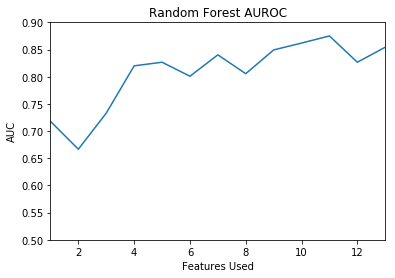

In [49]:
plt.plot(list(range(1,14)), roc_scores_RF)
plt.title('Random Forest AUROC') 
plt.xlabel('Features Used')
plt.ylabel('AUC')
plt.axis([1,13,0.5,0.9])

[1, 13, 0.5, 0.9]

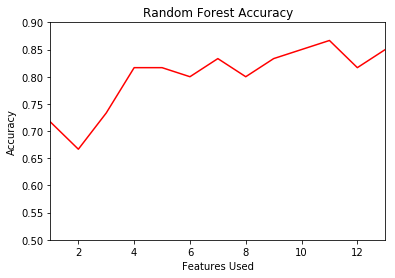

In [59]:
plt.plot(list(range(1,14)), test_scores_RF, 'r')
plt.title('Random Forest Accuracy') 
plt.xlabel('Features Used')
plt.ylabel('Accuracy')
plt.axis([1,13,0.5,0.9])

## KNN

In [9]:
print(len(X_train)*0.8)

189.60000000000002


In [10]:
feats = list(feat_ordered)
test_scores_KNN = []
roc_scores_KNN = []
for i in range(len(feat_ordered)):
    Xi_train = X_train[feats]
    n_list = list(range(5,185,5))
    n_list.insert(0, 1)
    n_list.append(189)
    parameters = {'n_neighbors': n_list}
    kn = GridSearchCV(neighbors.KNeighborsClassifier(), 
                             parameters, cv = 5, iid = True, 
                                  return_train_score = True, n_jobs=-1)
    kn.fit(Xi_train.values, y_train.values.ravel())
    test_score = kn.score(X_test[feats].values, y_test.values)
    test_scores_KNN.insert(0, test_score)
    ypred = kn.predict(X_test[feats].values)
    roc_score = roc_auc_score(ypred, y_test.values)
    roc_scores_KNN.insert(0,roc_score)
    del feats[0]

In [11]:
print(test_scores_KNN)
print(roc_scores_KNN)

[0.7333333333333333, 0.7333333333333333, 0.7833333333333333, 0.85, 0.85, 0.7833333333333333, 0.8166666666666667, 0.8166666666666667, 0.85, 0.8, 0.8333333333333334, 0.8166666666666667, 0.8166666666666667]
[0.7321428571428572, 0.75, 0.8003663003663003, 0.8542857142857142, 0.8542857142857142, 0.791421856639248, 0.826674500587544, 0.82, 0.8619271445358402, 0.813397129186603, 0.8402777777777778, 0.826674500587544, 0.826674500587544]


In [12]:
print("Best amount of features based on accuracy: " + 
      str([i+1 for i, x in enumerate(test_scores_KNN) if x == max(test_scores_KNN)]))
print("accuracy: " + str(max(test_scores_KNN)))
print('\n')
print("Best amount of features based on ROC AUC: " + 
      str([i+1 for i, x in enumerate(roc_scores_KNN) if x == max(roc_scores_KNN)]))
print("score: " + str(max(roc_scores_KNN)))

Best amount of features based on accuracy: [4, 5, 9]
accuracy: 0.85


Best amount of features based on ROC AUC: [9]
score: 0.8619271445358402


## Log Regression

[1, 13, 0.5, 0.9]

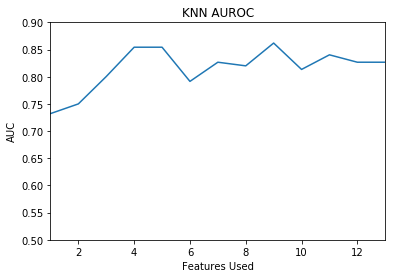

In [48]:
plt.plot(list(range(1,14)), roc_scores_KNN)
plt.title('KNN AUROC') 
plt.xlabel('Features Used')
plt.ylabel('AUC')
plt.axis([1,13,0.5,0.9])

[1, 13, 0.5, 0.9]

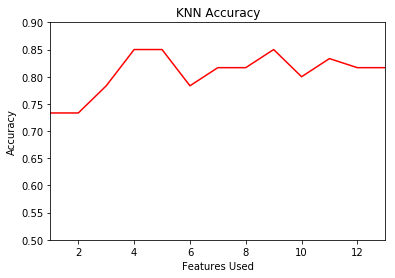

In [58]:
plt.plot(list(range(1,14)), test_scores_KNN, 'r')
plt.title('KNN Accuracy') 
plt.xlabel('Features Used')
plt.ylabel('Accuracy')
plt.axis([1,13,0.5,0.9])

In [13]:
feats = list(feat_ordered)
test_scores_LR = []
roc_scores_LR = []
for i in range(len(feat_ordered)):
    Xi_train = X_train[feats]
    C_list = [10**(-2), 10**(-1), 
              10**(0), 10**(1), 10**(2), 10**(3)]
    parameters = {'C': C_list}
    lr = GridSearchCV(linear_model.LogisticRegression(solver='lbfgs'),
                          parameters, cv = 5, iid = True, 
                                  return_train_score = True, n_jobs=-1)
    lr.fit(Xi_train.values, y_train.values.ravel())
    test_score = lr.score(X_test[feats].values, y_test.values)
    test_scores_LR.insert(0, test_score)
    ypred = lr.predict(X_test[feats].values)
    roc_score = roc_auc_score(ypred, y_test.values)
    roc_scores_LR.insert(0,roc_score)
    del feats[0]

In [14]:
print(test_scores_LR)
print(roc_scores_LR)

[0.75, 0.7333333333333333, 0.7666666666666667, 0.8333333333333334, 0.8333333333333334, 0.85, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.85, 0.85]
[0.7514285714285714, 0.75, 0.7875000000000001, 0.8348416289592759, 0.8348416289592759, 0.8542857142857142, 0.8348416289592759, 0.8402777777777778, 0.8402777777777778, 0.8402777777777778, 0.8492822966507176, 0.8619271445358402, 0.8619271445358402]


In [15]:
print("Best amount of features based on accuracy: " + 
      str([i+1 for i, x in enumerate(test_scores_LR) if x == max(test_scores_LR)]))
print("accuracy: " + str(max(test_scores_LR)))
print('\n')
print("Best amount of features based on ROC AUC: " + 
      str([i+1 for i, x in enumerate(roc_scores_LR) if x == max(roc_scores_LR)]))
print("score: " + str(max(roc_scores_LR)))

Best amount of features based on accuracy: [6, 12, 13]
accuracy: 0.85


Best amount of features based on ROC AUC: [12, 13]
score: 0.8619271445358402


[1, 13, 0.5, 0.9]

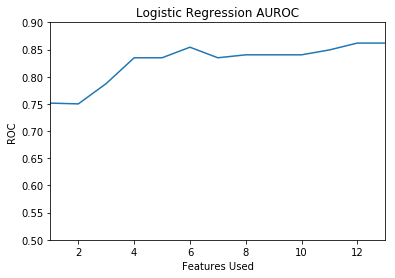

In [47]:
plt.plot(list(range(1,14)), roc_scores_LR)
plt.title('Logistic Regression AUROC') 
plt.xlabel('Features Used')
plt.ylabel('ROC')
plt.axis([1,13,0.5,0.9])

[1, 13, 0.5, 0.9]

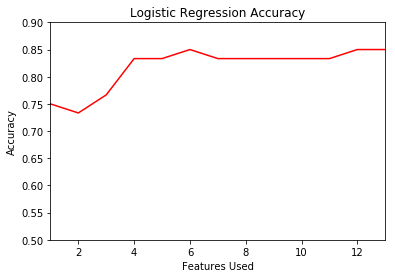

In [57]:
plt.plot(list(range(1,14)), test_scores_LR, 'r')
plt.title('Logistic Regression Accuracy') 
plt.xlabel('Features Used')
plt.ylabel('Accuracy')
plt.axis([1,13,0.5,0.9])

## SVM with Linear Kernel

In [16]:
feats = list(feat_ordered)
test_scores_SVM = []
roc_scores_SVM = []
for i in range(len(feat_ordered)):
    Xi_train = X_train[feats]
    C_list = [10**(-2), 10**(-1), 
              10**(0), 10**(1), 10**(2), 10**(3)]
    parameters = {'C': C_list}
    svmclf = GridSearchCV(svm.SVC(kernel = 'linear'), 
                            parameters, cv = 5, iid = True,
                            return_train_score = True, n_jobs=-1)
    svmclf.fit(Xi_train.values, y_train.values.ravel())
    test_score = svmclf.score(X_test[feats].values, y_test.values)
    test_scores_SVM.insert(0, test_score)
    ypred = svmclf.predict(X_test[feats].values)
    roc_score = roc_auc_score(ypred, y_test.values)
    roc_scores_SVM.insert(0,roc_score)
    del feats[0]

In [17]:
print(test_scores_SVM)
print(roc_scores_SVM)

[0.75, 0.7, 0.75, 0.8333333333333334, 0.8333333333333334, 0.85, 0.85, 0.8666666666666667, 0.85, 0.85, 0.8333333333333334, 0.85, 0.8333333333333334]
[0.7514285714285714, 0.7222222222222223, 0.7637362637362638, 0.8402777777777778, 0.8402777777777778, 0.8542857142857142, 0.8542857142857142, 0.8851674641148326, 0.8619271445358402, 0.8619271445358402, 0.8492822966507176, 0.8619271445358402, 0.8402777777777778]


In [18]:
print("Best amount of features based on accuracy: " + 
      str([i+1 for i, x in enumerate(test_scores_SVM) if x == max(test_scores_SVM)]))
print("accuracy: " + str(max(test_scores_SVM)))
print('\n')
print("Best amount of features based on ROC AUC: " + 
      str([i+1 for i, x in enumerate(roc_scores_SVM) if x == max(roc_scores_SVM)]))
print("score: " + str(max(roc_scores_SVM)))

Best amount of features based on accuracy: [8]
accuracy: 0.8666666666666667


Best amount of features based on ROC AUC: [8]
score: 0.8851674641148326


[1, 13, 0.5, 0.9]

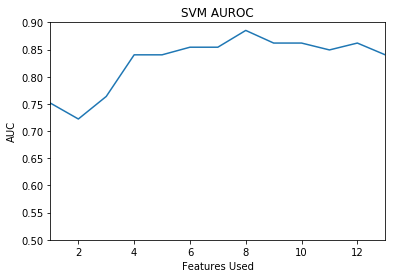

In [44]:
plt.plot(list(range(1,14)), roc_scores_SVM)
plt.title('SVM AUROC') 
plt.xlabel('Features Used')
plt.ylabel('AUC')
plt.axis([1,13,0.5,0.9])

[1, 13, 0.5, 0.9]

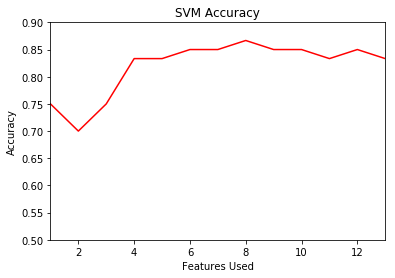

In [56]:
plt.plot(list(range(1,14)), test_scores_SVM, 'r')
plt.title('SVM Accuracy') 
plt.xlabel('Features Used')
plt.ylabel('Accuracy')
plt.axis([1,13,0.5,0.9])